# Sinusoid Regression: Impact of trajectory chunking
Notebook to analyze how the level of differences on which the PCA is calculated (e.g., global differences finetuned - pretrained or epoch-wise differences) affects performance.
We add more and more noise to the targets when finetuning on training tasks to see how this affects the PCA directions.

Before running this notebook, you need to follow the notebook `sinusoid-results.ipynb` to generate pretraining runs and calculate a preconditioning matrix.

Also, you need to calculate an additional preconditioning matrix with epoch-wise differences:
`python pca.py --base-dir experiments/sinusoid/runs/sinusoid-maml-5support_220219_195421/ --finetune-dirs experiments/sinusoid/runs/sinusoid-maml-5support_220219_195421/finetune_epoch50000/sin* --epoch 50000 --use-path 1 --n-runs 256`

In [121]:
%load_ext autoreload
%autoreload 2
import copy
import pickle
import sys
import os
from collections import defaultdict
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import scipy
import torch
from matplotlib import rc
from scipy.stats import ortho_group
from torch.nn.utils import parameters_to_vector
from tqdm import tqdm

sys.path.append('../..')
from tsfewshot import plot, analyses
from tsfewshot.config import Config
from tsfewshot.models import get_model
from tsfewshot.pcautils import load_diffs
from tsfewshot.utils import load_model

np.random.seed(0)
torch.random.manual_seed(0)

DEVICE = 'cuda:0'
SUPPORT_SIZE = 5
QUERY_SIZE = 100
MODEL_SIZE = 1761  # number of parameters in the 2-hidden-layer model
NOISE_LEVELS = [0.0, 0.15, 0.3, 0.5]  # noise levels to corrupt PCA trajectories

CODE_DIR = Path('../..')

rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# get the run directory from the meta-training phase
RUN = list(Path('runs/').glob(f'*maml-5support*'))[0].resolve()

In [3]:
# create tasks on which we will generate the finetuning trajectories that
# will be used to calculate the preconditioning matrix
np.random.seed(0)
amps = np.random.uniform(0.1, 5.0, size=MODEL_SIZE)
phases = np.random.uniform(0, np.pi, size=MODEL_SIZE)

finetune_tasks = [f'{amp}#{amp}#{phase}#{phase}#-5.0#5.0' for amp, phase in zip(amps, phases)][:256]

In [123]:
# create finetuning configurations for each of the above finetune_tasks
# we can reuse noise 0.0 from the sinusoid-results.ipynb notebook
for noise in NOISE_LEVELS[1:]:
    epoch = 50000
    (RUN / f'finetune_epoch{epoch}_noise{noise}/configs').mkdir(exist_ok=True, parents=True)
    for i, task in enumerate(finetune_tasks):
        cfg = Config(RUN / 'config.yml')

        cfg.update({
            'experiment_name': f'{cfg.experiment_name}-finetune-{task}',
            'batch_size': 64,
            'training_setup': 'supervised',
            # this is a quirk of tsfewshot: the "finetune" mode will finetune on the val_datasets
            # and evaluate on the test_datasets
            'val_datasets': [task],
            'test_datasets': [task],
            'finetune_lr': 0.001,
            'target_noise_std': noise,
            'optimizer': 'adam',
            'finetune_epochs': 500,
            'eval_every': 1,
            'early_stopping_patience': 10,
            'finetune': False,
            'save_every': 1,
            'checkpoint_path': f'{RUN}/model_epoch{str(epoch).zfill(3)}.p',
            'base_run_dir': str(RUN),
            'run_dir': f'{str(RUN)}/finetune_epoch{epoch}_noise{noise}'
        })

        cfg.dump_config(RUN / f'finetune_epoch{epoch}_noise{noise}/configs/{task.replace("#", "").replace("/", "")}.yml')

Next, you need to start the created finetuning runs. For each noise level, execute:
`python tsfewshot/run_scheduler.py finetune --directory /path/to/run/finetune_epoch50000_noiseN/configs/ --gpu-ids 0 --runs-per-gpu 5`
(adapt gpu-ids and runs-per-gpu according to the number and size of your GPU(s)).

After all runs are completed, calculate the preconditioning matrix for each noise level, once for global differences and once for epoch-wise differences (with `--use-path 1`):
`python pca.py --base-dir /path/to/run --finetune-dirs /path/to/run/finetune_epoch50000/sinusoid* --epoch 50000 {--use-path 1}`.
This will pickle the preconditioning matrix to `/path/to/run/pca/`.

In [112]:
ft_epochs = defaultdict(lambda: 200)

eval_every = list(range(20)) + list(range(20, 201, 10))
inner_seeds = [0]

type_specs = [
    'pca',  # differences calculated globally (finetuned - pretrained)
    'pca-path'  # epoch differences instead of global differences
]

gridsearch_dir = 'optimizeFinetune_chunking'
test_tasks = ['0.1#5.0#0.0#3.141592654#-5.0#5.0']

def combinations(noise, path=False):
    combinations = []
    for type_spec in type_specs:
        if (path and 'path' not in type_spec) or (not path and 'path' in type_spec):
            continue
        lrs = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005]
        for lr in lrs:
            combinations.append({'support': SUPPORT_SIZE,
                                 'lr': lr,
                                 'type': type_spec + f'-noise{noise}',
                                 'noise': 0.0,
                                 'sparsity': None,
                                })
    return combinations
    
len(combinations(0.0))

6

In [124]:
# create gridsearch for optimal learning rate and number of update steps during finetuning.
new_runs = []
cfg_update = {
    'batch_size': 64,
    'training_setup': 'supervised',
}
for method in ['global', 'epochs']:
    for noise in NOISE_LEVELS:
        suffix = f'_noise{noise}' if noise != 0.0 else ''
        if method == 'global':
            pca_file = RUN / f'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse{suffix}.p'
        if method == 'epochs':
            pca_file = RUN / f'pca/pca-torchcenterFalseNonecomponentspath1improvedFalseusestepsNonelayerwiseFalse{suffix}.p'
        new_runs += analyses.create_gridsearch_dirs(RUN,
                                                    combinations(noise, path=method=='epochs'),
                                                    gridsearch_dir,
                                                    inner_seeds,
                                                    n_trajectories=-1,
                                                    query_size=QUERY_SIZE,
                                                    ft_epochs=ft_epochs,
                                                    eval_every=eval_every,
                                                    save_predictions=False,
                                                    optimizer='sgd-squared',
                                                    val_datasets=test_tasks,
                                                    n_dataset_evals=100,
                                                    init_epoch=50000,
                                                    tasks_ds_cfg=cfg_update,
                                                    pca_file_path=pca_file)
[r.name for r in new_runs]

100%|██████████| 6/6 [00:00<00:00, 40.88it/s]


['support5_lr1.0_pca-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.5_pca-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.1_pca-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.05_pca-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.01_pca-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.005_pca-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr1.0_pca-path-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.5_pca-path-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.1_pca-path-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.05_pca-path-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.01_pca-path-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.005_pca-path-noise0.5_sparseNone_noise0.0_seed0']

Next, run the created gridsearch configurations via:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_chunking/ --epoch 50000 --split val --gpu-ids 0 --runs-per-gpu 5`.

In [125]:
best_ft_options = {}
best_ft_epochs = {}
gridsearch_results = {}

In [126]:
# load the gridsearch results and calculate the best learning rate and number of update steps
# for each method.
# For the best configuration of each method, we create a final finetuning experiment
# that we'll use to analyze the results.
new_run_dirs = []
for noise in NOISE_LEVELS:
    for method in ['global', 'epochs']:
        out = analyses.create_final_finetune_dirs([RUN],
                                              [SUPPORT_SIZE],
                                              combinations(noise, path=method=='epochs'),
                                              inner_seeds,
                                              gridsearch_dir,
                                              test_tasks,
                                              n_dataset_evals=100,
                                              best_ft_options=best_ft_options,
                                              best_ft_epochs=best_ft_epochs,
                                              n_results=100,
                                              metric_aggregation='mean',
                                              metric_name='mse')
        new_run_dirs += out[0]
        best_ft_options.update(out[1])
        best_ft_epochs.update(out[2])
        gridsearch_results.update(out[3])
[r.name for r in new_run_dirs]

5
support size: 5    pca-noise0.0 noise 0.0                                                           LR: 0.5    epochs: 190  
5
support size: 5    pca-noise0.0 noise 0.0                                                           LR: 0.5    epochs: 190  
support size: 5    pca-path-noise0.0 noise 0.0                                                      LR: 0.1    epochs: 110  
5
support size: 5    pca-noise0.0 noise 0.0                                                           LR: 0.5    epochs: 190  
support size: 5    pca-noise0.15 noise 0.0                                                          LR: 0.1    epochs: 190  
support size: 5    pca-path-noise0.0 noise 0.0                                                      LR: 0.1    epochs: 110  
5
support size: 5    pca-noise0.0 noise 0.0                                                           LR: 0.5    epochs: 190  
support size: 5    pca-noise0.15 noise 0.0                                                          LR: 0.1    epochs

['support5_lr0.1_pca-noise0.5_sparseNone_noise0.0_seed0',
 'support5_lr0.1_pca-path-noise0.5_sparseNone_noise0.0_seed0']

Next, run the final finetuning experiments:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_chunking_finalFinetune/ --epoch 50000 --split test --gpu-ids 0 --runs-per-gpu 5`.

In [128]:
# load the result from final finetuning
metrics = None
all_combinations = sum(((combinations(n) + combinations(n, path=True)) for n in NOISE_LEVELS), start=[])
metrics = analyses.get_final_metrics([RUN],
                                     noises=[0.0],
                                     support_sizes=[SUPPORT_SIZE],
                                     combinations=all_combinations,
                                     best_ft_options=best_ft_options,
                                     inner_seeds=inner_seeds,
                                     query_size=QUERY_SIZE,
                                     n_trajectories=-1,
                                     test_tasks=test_tasks,
                                     gridsearch_dir=gridsearch_dir,
                                     init_epoch=50000,
                                     metrics=metrics,
                                     metric_name='mse',
                                     metric_file_name='mse',
                                     metric_aggregation='mean',
                                     no_ft_eval=False)

5


In [118]:
# dump results so we don't have to recalculate each time we run this notebook
pickle.dump(metrics, (RUN / 'metrics_chunking.p').open('wb'))
pickle.dump(best_ft_options, (RUN / 'best_ft_options_chunking.p').open('wb'))
pickle.dump(best_ft_epochs, (RUN / 'best_ft_epochs_chunking.p').open('wb'))

In [129]:
df_norms = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_norms.columns.names = ['support', 'type', 'seed']

# results table
display_df = df_norms.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).mean(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


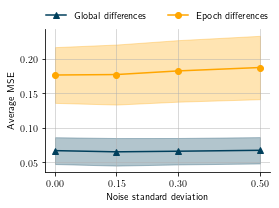

In [133]:
# plot results
def plot_noise_vs_mse(df: pd.DataFrame, noises: list,
                      types: list,
                      style=None,
                      alpha=0.6,
                      figsize=(5, 5)):
    f, axs = plt.subplots(1, 1, figsize=figsize)
    axs = [axs]
    plt.setp(axs[0], xticks=noises)

    vals = df.loc[:, SUPPORT_SIZE].stack(level='seed')

    n_typs = len(types)
    for i, type_name in enumerate(types):
        typ_means, lower, upper = [], [], []
        for noise in noises:
            typ = f'{type_name}-noise{noise} noise 0.0 '
            typ_vals = vals.loc[:, typ]
            typ_means.append(typ_vals.mean(axis=0))
            ci = 1.96 * typ_vals.std(axis=0) / np.sqrt(typ_vals.shape[0])
            lower.append(typ_means[-1] - ci)
            upper.append(typ_means[-1] + ci)

        ls, col, label, marker = plot.get_style(typ)
        if style is not None:
            ls = style[type_name].get('ls', ls)
            col = style[type_name].get('col', col)
            label = style[type_name].get('label', label)
            marker = style[type_name].get('marker', marker)

        axs[0].plot(noises, typ_means, ls=ls, label=label, c=col, marker=marker)
        axs[0].fill_between(noises, lower, upper, color=col, alpha=alpha)

    axs[0].set_ylabel('Average MSE')
    for ax in axs:
        ax.grid(alpha=0.6)
        ax.set_xlabel('Noise standard deviation')
        ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=3)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    _ = plt.tight_layout()
    return f

figsize = (4, 3)
style = {
    'pca-path': {'ls': '-', 'col': '#ffa600', 'marker': 'o', 'label': 'Epoch differences'},
    'pca': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'Global differences'},
}
f = plot_noise_vs_mse(df_norms,
                      NOISE_LEVELS,
                      type_specs,
                      figsize=figsize,
                      alpha=0.3,
                      style=style)
f.savefig('plots/sinusoid-chunking-vs-mse-mean.pdf', bbox_inches='tight')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:    0.9s finished
100%|██████████| 256/256 [00:09<00:00, 26.71it/s] 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:    0.9s finished
100%|██████████| 256/256 [00:04<00:00, 59.32it/s] 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:    0.9s finished
100%|██████████| 256/256 [00:04<00:00, 59.01it/s] 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:    3.7s finished
100%|██████████| 256/256 [00:04<00:00, 59.60it/s] 


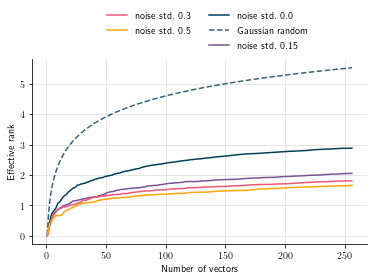

In [132]:
plt.figure(figsize=(5.3, 4))
cols = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
for i, noise in enumerate(NOISE_LEVELS):
    suffix = f'_noise{noise}' if noise != 0.0 else ''
    finetune_dirs = list((RUN / f'finetune_epoch50000{suffix}').glob('sinus*/'))[:256]
    cfg = Config(RUN / 'config.yml')
    f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                              tols=[0],
                              ax=plt.gca(),
                              random_baseline=i==0,
                              n_repeats=1,
                              task_steps=1,
                              within_task_steps=None,
                              colors=[cols[i]],
                              epoch_steps=None,
                              use_erank=True,
                              init_epoch=-1,
                              plot_details=False,
                              plot_val_metric=False,
                              label_suffix=f' noise std.\ {noise}')
plt.tight_layout()